# Lib import

In [1]:
import numpy as np
import networkx as nx
import hypernetx.algorithms.hypergraph_modularity as hmod
import pandas as pd
import igraph as ig
import hypernetx as hnx
import random
import matplotlib.pyplot as plt
import seaborn as sns
import math
from itertools import combinations
from PyComplexHeatmap import *
import pickle

import sys
sys.path.append('/gpfs/commons/groups/gursoy_lab/ajoglekar/Projects/2023_03_01_multiwayInteractions/v0.analysis/scripts/pythonScripts/functions/')
from edgeWeightFormulations import *
from hnxClusteringFunctions import *
from simulatingHypergraphs import *

# Functions

# Begin simulations

Let's start with about 400 reads across 16 bins. Ideally we want clustering to occur as follows:
Bin 1-2: Clust 1, Bins 3-6: Clust 2, Bins 7-9: Clust 3, Bin 10-11: Clust 4, Bin 12-14: Clust 5, Bin 15-16: Clust6

We will do this under 3 paradigms:
- Fully insulated: Each read only has within-cluster connections
- Partially insulated: Most reads has within-cluster connections, but hypergraph is fully connected
- Realistic matrix: Nested TAD structures visible

### Setup

In [16]:
## Set up. 
dataDir = '/gpfs/commons/groups/gursoy_lab/ajoglekar/Projects/2023_03_01_multiwayInteractions/2023_03_01_v0_dataGathering/v0_hypergraphSimulations/'
## Get read - cardinality frequency distribution
numReadsPerCard = pd.read_csv(f'{dataDir}numReadsPerCard_fromChr19.tab',sep = "\t")
## Get frequency of length distributions given cardinality
with open(f'{dataDir}freqLensGivenCard.pkl', 'rb') as pickle_file:
    freqLenPerCard = pickle.load(pickle_file)

## matrix specifications:
ncol = 1000
nrow = 16
binIDs = ['bin{}'.format(i) for i in range(1, (nrow+1))]
readIDs = ['read{}'.format(i) for i in range(1, (ncol+1))]
mt = pd.DataFrame(np.zeros(shape = (nrow,ncol)), index=binIDs, columns=readIDs)

## Cluster assignment by bins for simulations
numClusters = 6
clusterNames = [i for i in range(1,numClusters+1)]
clusterFreqs = [2,4,3,2,3,2] ## specified by me in study design
clustIDs = flatten([[clusterNames[i]]*clusterFreqs[i] for i in range(len(clusterNames))]) ## as specified above
binClust = dict(zip(binIDs, clustIDs))

## Assigning random cardinalities and clusters to each read
seed = 100
random.seed(seed)
readCards = random.choices(numReadsPerCard['Cardinality'][range(nrow)],k = ncol, weights=numReadsPerCard['perc'][range(nrow)])
random.seed(seed)
groundTruth_clusters = random.choices(clusterNames,k = ncol, weights = clusterFreqs)

global binClust,freqLenPerCard

### Fully insulated incidence matrix

#### Generate matrix

In [135]:
mt_fi = mt.copy()
for ix in range(len(readCards)):
    bins2modify = fullyInsulatedBinIDs(ix,readCards,groundTruth_clusters)
    mt_fi[readIDs[ix]][bins2modify] = 1

In [136]:
fIn = hnx.Hypergraph.from_incidence_dataframe(mt_fi)
print(fIn.number_of_nodes())
print(fIn.number_of_edges())

fIn_mE = fIn.collapse_edges(use_reps = True, return_counts = True)
print(fIn_mE.number_of_nodes())
print(fIn_mE.number_of_edges())

16
1000
16
33


#### Plot multiedge hypergraph

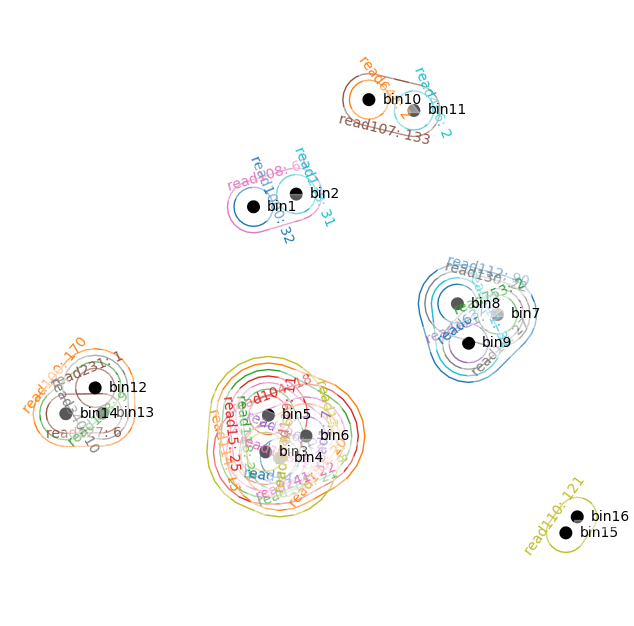

In [137]:
hnx.draw(fIn_mE)

#### Plot incidence DF

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..


/gpfs/commons/home/ajoglekar/.conda/envs/noush_base/envs/hypergraph_poreC/lib/python3.10/site-packages/PyComplexHeatmap/clustermap.py:637: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


Plotting legends..


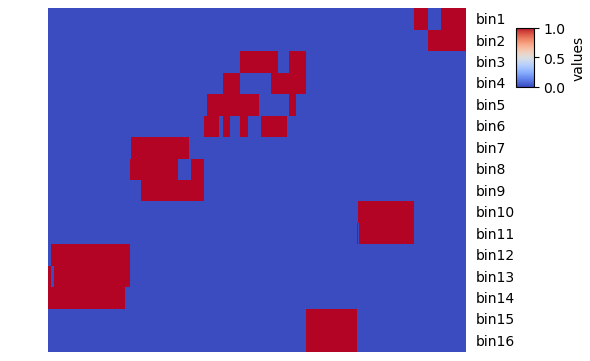

In [138]:
plt.figure(figsize=(6, 4))
cm = ClusterMapPlotter(data=mt_fi,
                       col_cluster=True,row_cluster=False,
                       label='values',row_dendrogram=True,
                       show_rownames=True,show_colnames=False,
                       cmap='coolwarm',xticklabels_kws={'labelrotation':-90,'labelcolor':'blue'})
plt.show()

#### Plot HiC matrix

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Plotting legends..


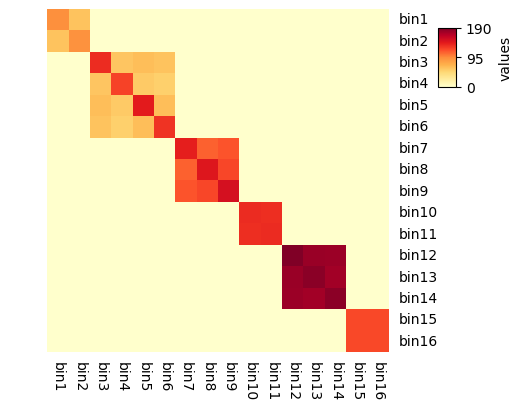

In [139]:
fI_hiC = makeHiC_fromInc(mt_fi)
plt.figure(figsize=(5, 4))
cm = ClusterMapPlotter(data=fI_hiC,
        col_cluster=False,row_cluster=False,
        label='values',row_dendrogram=True,
        show_rownames=True,show_colnames=True,
        cmap='YlOrRd',#xticklabels_kws={'labelrotation':-90,'labelcolor':'blue'}
        )
plt.show()

#### Clustering methods

##### Raw

In [140]:
rand_qh, kumClust, louClust = compareClusteringMethods(fIn,numClusters)

6  random clusters, qH =  -0.03768241377378623
Num kumar clusters =  6
Kumar qH = 0.6732680838529923
[{'bin8', 'bin9', 'bin7'}, {'bin14', 'bin13', 'bin12'}, {'bin3', 'bin4', 'bin6', 'bin5'}, {'bin11', 'bin10'}, {'bin2', 'bin1'}, {'bin16', 'bin15'}]
Num 2-section Louvain clusters =  6
Louvain qH = 0.6732680838529923
[{'bin8', 'bin9', 'bin7'}, {'bin14', 'bin13', 'bin12'}, {'bin3', 'bin4', 'bin6', 'bin5'}, {'bin11', 'bin10'}, {'bin2', 'bin1'}, {'bin16', 'bin15'}]


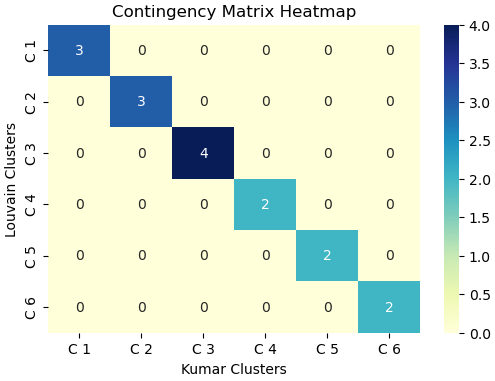

In [141]:
plotAlgoComparison(kumClust,louClust,"Kumar","Louvain")

### Partially insulated

#### Generate matrix

In [17]:
mt_pi = mt.copy()
for ix in range(len(readCards)):
    bins2modify = partiallyInsulatedBinIDs(ix,readCards,groundTruth_clusters,0.75)
    mt_pi[readIDs[ix]][bins2modify] = 1

In [18]:
pIn = hnx.Hypergraph.from_incidence_dataframe(mt_pi)
print(pIn.number_of_nodes())
print(pIn.number_of_edges())

pIn_mE = pIn.collapse_edges(use_reps = True, return_counts = True)
print(pIn_mE.number_of_nodes())
print(pIn_mE.number_of_edges())

16
1000
16
290


#### Plot multiedge hypergraph

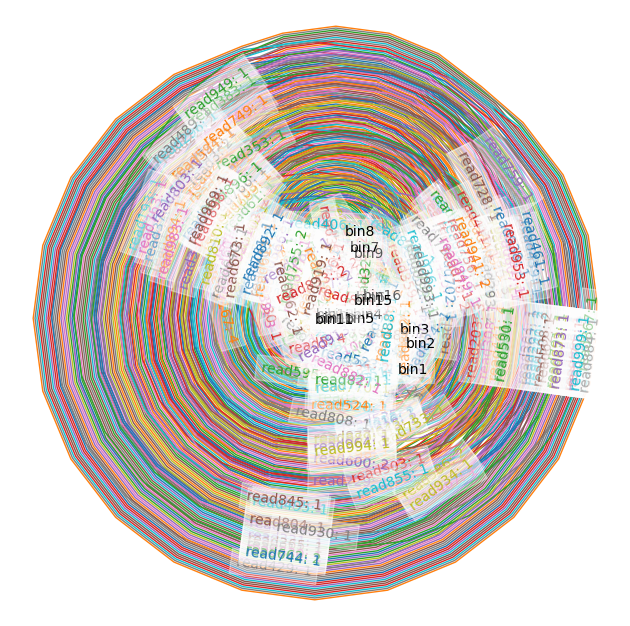

In [19]:
hnx.draw(pIn_mE)

#### Plot incidence DF

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..


/gpfs/commons/home/ajoglekar/.conda/envs/noush_base/envs/hypergraph_poreC/lib/python3.10/site-packages/PyComplexHeatmap/clustermap.py:637: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


Plotting legends..


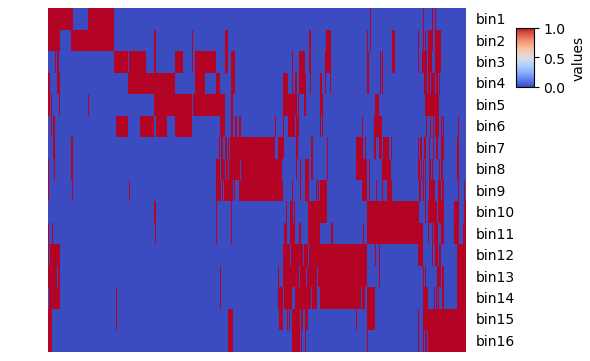

In [20]:
plt.figure(figsize=(6, 4))
cm = ClusterMapPlotter(data=mt_pi,
                       col_cluster=True,row_cluster=False,
                       label='values',row_dendrogram=True,
                       show_rownames=True,show_colnames=False,
                       cmap='coolwarm',xticklabels_kws={'labelrotation':-90,'labelcolor':'blue'})
plt.show()

#### Plot HiC matrix

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Plotting legends..


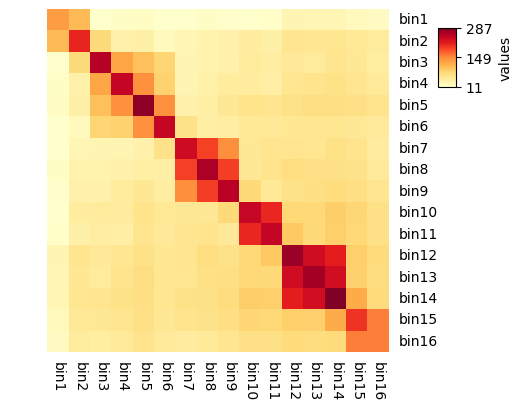

In [21]:
pI_hiC = makeHiC_fromInc(mt_pi)
plt.figure(figsize=(5, 4))
cm = ClusterMapPlotter(data=pI_hiC,
        col_cluster=False,row_cluster=False,
        label='values',row_dendrogram=True,
        show_rownames=True,show_colnames=True,
        cmap='YlOrRd')
plt.show()

#### Clustering methods

##### Raw

In [22]:
rand_qh_pI, kumClust_pI, louClust_pI = compareClusteringMethods(pIn,K = numClusters)

6  random clusters, qH =  -0.20265132291647997
Num kumar clusters =  5
Kumar qH = 0.375977510088421
[{'bin7', 'bin8', 'bin9'}, {'bin1', 'bin2'}, {'bin14', 'bin12', 'bin16', 'bin13', 'bin15'}, {'bin3', 'bin4', 'bin5', 'bin6'}, {'bin10', 'bin11'}]
Num 2-section Louvain clusters =  5
Louvain qH = 0.375977510088421
[{'bin7', 'bin8', 'bin9'}, {'bin1', 'bin2'}, {'bin14', 'bin12', 'bin16', 'bin13', 'bin15'}, {'bin3', 'bin4', 'bin5', 'bin6'}, {'bin10', 'bin11'}]


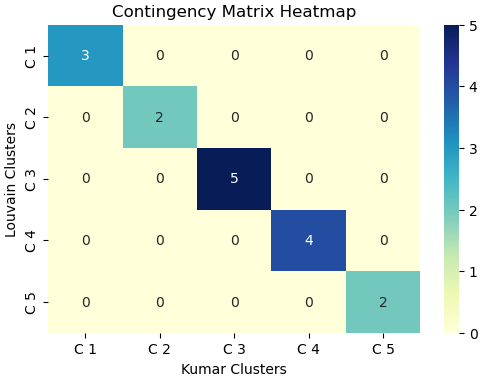

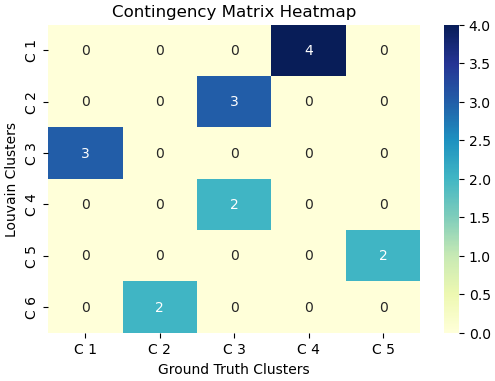

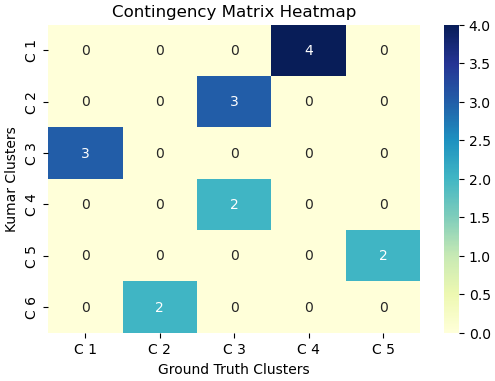

In [23]:
groundTruth = [{'bin4', 'bin5', 'bin6', 'bin3'}, {'bin12', 'bin14', 'bin13'}, 
{'bin7', 'bin8', 'bin9'}, {'bin16', 'bin15'}, {'bin11', 'bin10'}, {'bin2', 'bin1'}]

plotAlgoComparison(kumClust_pI,louClust_pI,"Kumar","Louvain")
plotAlgoComparison(groundTruth,louClust_pI,"Ground Truth","Louvain")
plotAlgoComparison(groundTruth,kumClust_pI,"Ground Truth","Kumar")

##### Unbounded weight

In [190]:
unBoundedWeights = pd.Series([unbounded_withLength(list(mt_pi[c])) for c in mt_pi.columns], index=mt_pi.columns)
for e in pIn.edges:
    pIn.edges[e].weight = unBoundedWeights[e]
rand_qh_pI_unB, kumClust_pI_unB, louClust_pI_unB = compareClusteringMethods(pIn,K = numClusters)

6  random clusters, qH =  -0.10083078897266776
Num kumar clusters =  6
Kumar qH = 0.32159264336827253
[{'bin3', 'bin5', 'bin6', 'bin4'}, {'bin8', 'bin9', 'bin7'}, {'bin14', 'bin13', 'bin12'}, {'bin16', 'bin15'}, {'bin11', 'bin10'}, {'bin2', 'bin1'}]
Num 2-section Louvain clusters =  4
Louvain qH = 0.31392238163460523
[{'bin3', 'bin5', 'bin6', 'bin4'}, {'bin8', 'bin9', 'bin7'}, {'bin14', 'bin13', 'bin12'}, {'bin2', 'bin15', 'bin16', 'bin10', 'bin1', 'bin11'}]


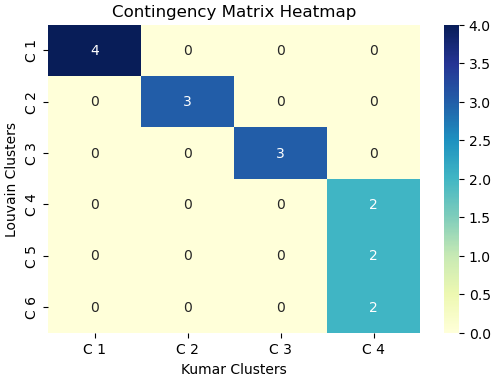

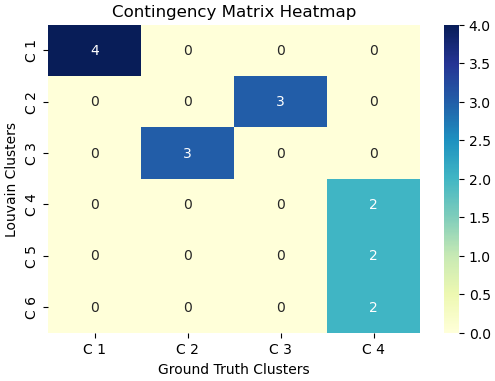

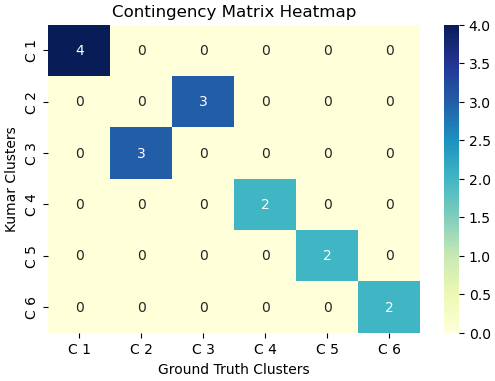

In [191]:
groundTruth = [{'bin4', 'bin5', 'bin6', 'bin3'}, {'bin12', 'bin14', 'bin13'}, 
{'bin7', 'bin8', 'bin9'}, {'bin16', 'bin15'}, {'bin11', 'bin10'}, {'bin2', 'bin1'}]

plotAlgoComparison(kumClust_pI_unB,louClust_pI_unB,"Kumar","Louvain")
plotAlgoComparison(groundTruth,louClust_pI_unB,"Ground Truth","Louvain")
plotAlgoComparison(groundTruth,kumClust_pI_unB,"Ground Truth","Kumar")

##### Bounded weight

In [192]:
boundedWeights = pd.Series([bounded_noLength(list(mt_pi[c])) for c in mt_pi.columns], index=mt_pi.columns)
for e in pIn.edges:
    pIn.edges[e].weight = boundedWeights[e]
rand_qh_pI_B, kumClust_pI_B, louClust_pI_B = compareClusteringMethods(pIn,K = numClusters)

6  random clusters, qH =  -0.030195034511628915
Num kumar clusters =  6
Kumar qH = 0.4352873741574635
[{'bin3', 'bin5', 'bin6', 'bin4'}, {'bin8', 'bin9', 'bin7'}, {'bin14', 'bin13', 'bin12'}, {'bin16', 'bin15'}, {'bin11', 'bin10'}, {'bin2', 'bin1'}]
Num 2-section Louvain clusters =  6
Louvain qH = 0.4352873741574635
[{'bin3', 'bin5', 'bin6', 'bin4'}, {'bin8', 'bin9', 'bin7'}, {'bin14', 'bin13', 'bin12'}, {'bin16', 'bin15'}, {'bin11', 'bin10'}, {'bin2', 'bin1'}]


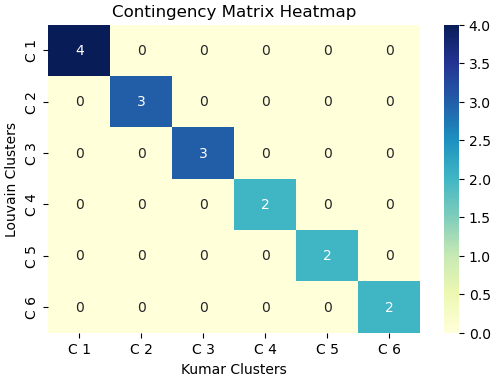

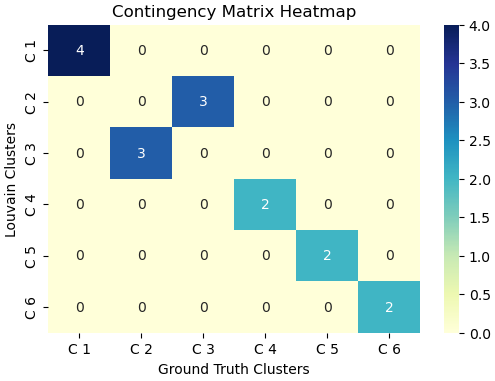

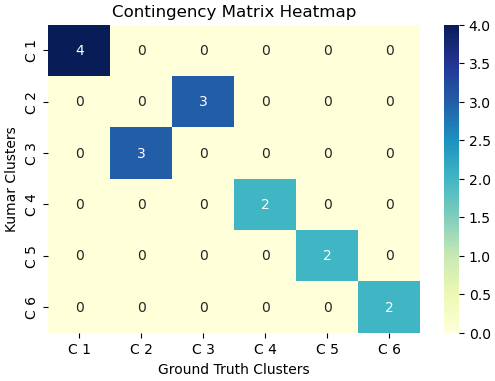

In [193]:
groundTruth = [{'bin4', 'bin5', 'bin6', 'bin3'}, {'bin12', 'bin14', 'bin13'}, 
{'bin7', 'bin8', 'bin9'}, {'bin16', 'bin15'}, {'bin11', 'bin10'}, {'bin2', 'bin1'}]

plotAlgoComparison(kumClust_pI_B,louClust_pI_B,"Kumar","Louvain")
plotAlgoComparison(groundTruth,louClust_pI_B,"Ground Truth","Louvain")
plotAlgoComparison(groundTruth,kumClust_pI_B,"Ground Truth","Kumar")

#### Bounded with length frequency given card

In [24]:
boundedLFWeights = pd.Series([bounded_lengthFreq(list(mt_pi[c])) for c in mt_pi.columns], index=mt_pi.columns)
for e in pIn.edges:
    pIn.edges[e].weight = boundedLFWeights[e]
rand_qh_pI_BLF, kumClust_pI_BLF, louClust_pI_BLF = compareClusteringMethods(pIn,K = numClusters)

6  random clusters, qH =  -0.17613775069926726
Num kumar clusters =  4
Kumar qH = 0.4553389331827305
[{'bin7', 'bin8', 'bin9'}, {'bin1', 'bin2'}, {'bin10', 'bin14', 'bin12', 'bin16', 'bin13', 'bin15', 'bin11'}, {'bin3', 'bin4', 'bin5', 'bin6'}]
Num 2-section Louvain clusters =  4
Louvain qH = 0.4553389331827305
[{'bin7', 'bin8', 'bin9'}, {'bin1', 'bin2'}, {'bin10', 'bin14', 'bin12', 'bin16', 'bin13', 'bin15', 'bin11'}, {'bin3', 'bin4', 'bin5', 'bin6'}]


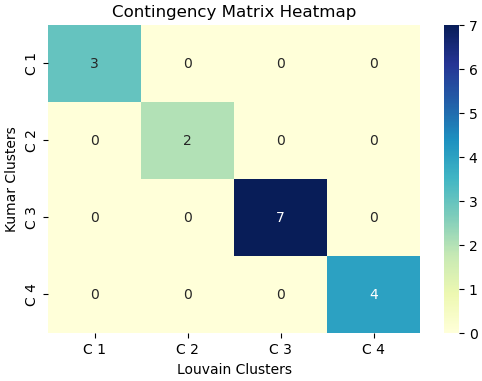

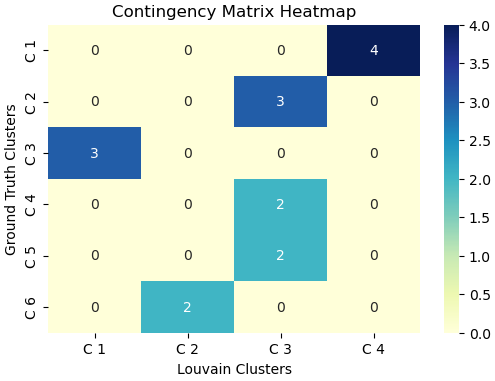

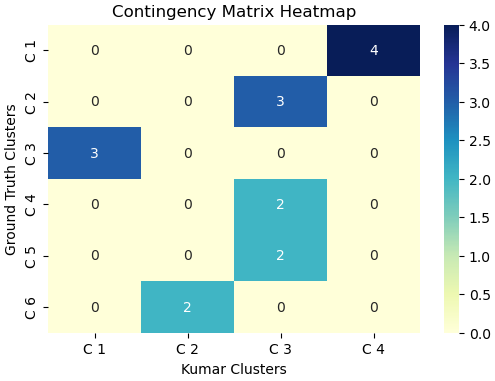

In [26]:
groundTruth = [{'bin4', 'bin5', 'bin6', 'bin3'}, {'bin12', 'bin14', 'bin13'}, 
{'bin7', 'bin8', 'bin9'}, {'bin16', 'bin15'}, {'bin11', 'bin10'}, {'bin2', 'bin1'}]

plotAlgoComparison(kumClust_pI_BLF,louClust_pI_BLF,"Louvain","Kumar")
plotAlgoComparison(groundTruth,louClust_pI_BLF,"Louvain","Ground Truth")
plotAlgoComparison(groundTruth,kumClust_pI_BLF,"Kumar","Ground Truth")

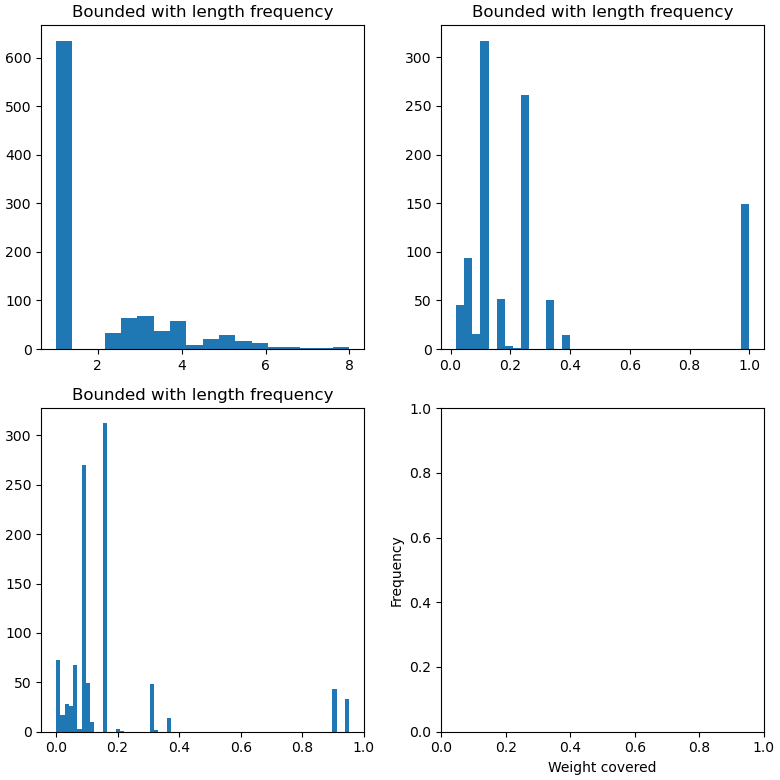

In [196]:
# Generate histogram of weights

f, axs = plt.subplots(
    figsize=(8,8),
    ncols=2, nrows = 2)

ax = axs[0,0]
ax.hist(unBoundedWeights, bins='auto')
ax.set_title('Bounded with length frequency')

ax = axs[0,1]
ax.hist(boundedWeights, bins='auto')
ax.set_title('Bounded with length frequency')

ax = axs[1,0]
ax.hist(boundedLFWeights, bins='auto')
ax.set_title('Bounded with length frequency')

# Display the histogram
plt.xlabel('Weight covered')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

### Realistic matrix with nested TADs

#### Generate matrix

In [159]:
mt_realistic = mt.copy()
secondaryClusts = ["S1","S2"]
sClustAssignFreqs = [7,5]
secondaryClustBins = ['bin{}'.format(i) for i in range(3,15)]
sClustIDs = flatten([[secondaryClusts[i]]*sClustAssignFreqs[i] for i in range(len(secondaryClusts))])
secBinClust = dict(zip(secondaryClustBins, sClustIDs))

for ix in range(len(readCards)):
    bins2modify = realisticNestedTADs(ix,readCards,groundTruth_clusters,0.75)
    mt_realistic[readIDs[ix]][bins2modify] = 1

In [160]:
rIn = hnx.Hypergraph.from_incidence_dataframe(mt_realistic)
print(rIn.number_of_nodes())
print(rIn.number_of_edges())

rIn_mE = rIn.collapse_edges(use_reps = True, return_counts = True)
print(rIn_mE.number_of_nodes())
print(rIn_mE.number_of_edges())

16
1000
16
154


#### Plot multiedge hypergraph

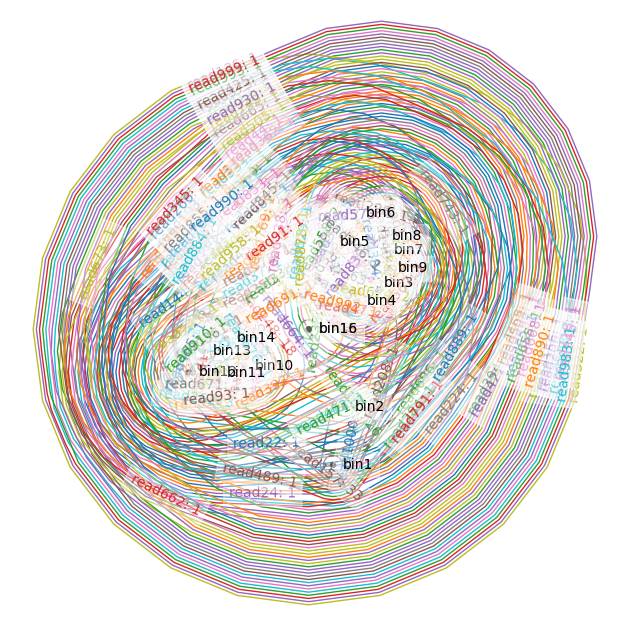

In [161]:
hnx.draw(rIn_mE)

#### Plot incidence DF

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..


/gpfs/commons/home/ajoglekar/.conda/envs/noush_base/envs/hypergraph_poreC/lib/python3.10/site-packages/PyComplexHeatmap/clustermap.py:637: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


Plotting legends..


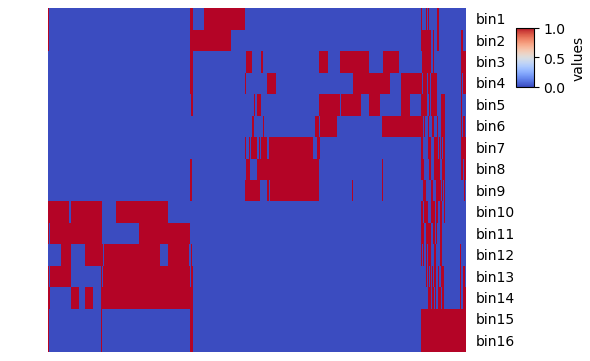

In [162]:
plt.figure(figsize=(6, 4))
cm = ClusterMapPlotter(data=mt_realistic,
                       col_cluster=True,row_cluster=False,
                       label='values',row_dendrogram=True,
                       show_rownames=True,show_colnames=False,
                       cmap='coolwarm',xticklabels_kws={'labelrotation':-90,'labelcolor':'blue'})
plt.show()

#### Plot HiC matrix

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Plotting legends..


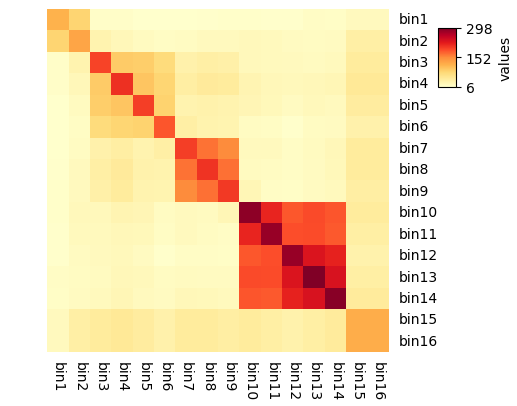

In [163]:
rI_hiC = makeHiC_fromInc(mt_realistic)
plt.figure(figsize=(5, 4))
cm = ClusterMapPlotter(data=rI_hiC,
        col_cluster=False,row_cluster=False,
        label='values',row_dendrogram=True,
        show_rownames=True,show_colnames=True,
        cmap='YlOrRd')
plt.show()

#### Clustering methods

##### Raw

In [130]:
compareClusteringMethods(rIn,K = 5)

5  random clusters, qH =  -0.08845371765872162
Num kumar clusters =  4
Kumar qH = 0.47854202592837186
[{'bin13', 'bin10', 'bin14', 'bin12', 'bin11'}, {'bin8', 'bin9', 'bin7'}, {'bin4', 'bin6', 'bin5', 'bin3'}, {'bin16', 'bin2', 'bin15', 'bin1'}]
Num 2-section Louvain clusters =  4
Louvain qH = 0.47854202592837186
[{'bin13', 'bin10', 'bin14', 'bin12', 'bin11'}, {'bin8', 'bin9', 'bin7'}, {'bin4', 'bin6', 'bin5', 'bin3'}, {'bin16', 'bin2', 'bin15', 'bin1'}]


[-0.08845371765872162,
 [{'bin10', 'bin11', 'bin12', 'bin13', 'bin14'},
  {'bin7', 'bin8', 'bin9'},
  {'bin3', 'bin4', 'bin5', 'bin6'},
  {'bin1', 'bin15', 'bin16', 'bin2'}],
 [{'bin10', 'bin11', 'bin12', 'bin13', 'bin14'},
  {'bin7', 'bin8', 'bin9'},
  {'bin3', 'bin4', 'bin5', 'bin6'},
  {'bin1', 'bin15', 'bin16', 'bin2'}]]

#### Introduce weights

##### Unbounded

In [178]:
unBoundedWeights = pd.Series([unbounded_withLength(list(mt_realistic[c])) for c in mt_realistic.columns], index=mt_realistic.columns)
for e in rIn.edges:
    rIn.edges[e].weight = unBoundedWeights[e]
compareClusteringMethods(rIn,K = 4)

4  random clusters, qH =  -0.15150733759757443
Num kumar clusters =  4
Kumar qH = 0.428200181931652
[{'bin8', 'bin9', 'bin7'}, {'bin13', 'bin10', 'bin14', 'bin12', 'bin11'}, {'bin16', 'bin2', 'bin15', 'bin1'}, {'bin3', 'bin5', 'bin6', 'bin4'}]
Num 2-section Louvain clusters =  3
Louvain qH = 0.3779626693746431
[{'bin6', 'bin7', 'bin3', 'bin9', 'bin8', 'bin4', 'bin5'}, {'bin13', 'bin10', 'bin14', 'bin12', 'bin11'}, {'bin16', 'bin2', 'bin15', 'bin1'}]


[-0.15150733759757443,
 [{'bin7', 'bin8', 'bin9'},
  {'bin10', 'bin11', 'bin12', 'bin13', 'bin14'},
  {'bin1', 'bin15', 'bin16', 'bin2'},
  {'bin3', 'bin4', 'bin5', 'bin6'}],
 [{'bin3', 'bin4', 'bin5', 'bin6', 'bin7', 'bin8', 'bin9'},
  {'bin10', 'bin11', 'bin12', 'bin13', 'bin14'},
  {'bin1', 'bin15', 'bin16', 'bin2'}]]

##### Bounded

In [179]:
boundedWeights = pd.Series([bounded_noLength(list(mt_realistic[c])) for c in mt_realistic.columns], index=mt_realistic.columns)
for e in rIn.edges:
    rIn.edges[e].weight = boundedWeights[e]
compareClusteringMethods(rIn,K = 4)

4  random clusters, qH =  -0.024169190517168815
Num kumar clusters =  4
Kumar qH = 0.4371505160870758
[{'bin8', 'bin9', 'bin7'}, {'bin13', 'bin10', 'bin14', 'bin12', 'bin11'}, {'bin16', 'bin2', 'bin15', 'bin1'}, {'bin3', 'bin5', 'bin6', 'bin4'}]
Num 2-section Louvain clusters =  5
Louvain qH = 0.4459303116391887
[{'bin8', 'bin9', 'bin7'}, {'bin13', 'bin10', 'bin14', 'bin12', 'bin11'}, {'bin2', 'bin1'}, {'bin3', 'bin5', 'bin6', 'bin4'}, {'bin16', 'bin15'}]


[-0.024169190517168815,
 [{'bin7', 'bin8', 'bin9'},
  {'bin10', 'bin11', 'bin12', 'bin13', 'bin14'},
  {'bin1', 'bin15', 'bin16', 'bin2'},
  {'bin3', 'bin4', 'bin5', 'bin6'}],
 [{'bin7', 'bin8', 'bin9'},
  {'bin10', 'bin11', 'bin12', 'bin13', 'bin14'},
  {'bin1', 'bin2'},
  {'bin3', 'bin4', 'bin5', 'bin6'},
  {'bin15', 'bin16'}]]

### Bounded with length frequency given card

In [180]:
boundedLFWeights = pd.Series([bounded_lengthFreq(list(mt_realistic[c])) for c in mt_realistic.columns], index=mt_realistic.columns)
for e in rIn.edges:
    rIn.edges[e].weight = boundedLFWeights[e]
rand_qh_pI_BLF, kumClust_pI_BLF, louClust_pI_BLF = compareClusteringMethods(rIn,K = 4)

4  random clusters, qH =  -0.022592615231060653
Num kumar clusters =  4
Kumar qH = 0.5330451956665441
[{'bin8', 'bin9', 'bin7'}, {'bin13', 'bin10', 'bin14', 'bin12', 'bin11'}, {'bin16', 'bin2', 'bin15', 'bin1'}, {'bin3', 'bin5', 'bin6', 'bin4'}]
Num 2-section Louvain clusters =  5
Louvain qH = 0.5366294748468641
[{'bin8', 'bin9', 'bin7'}, {'bin13', 'bin10', 'bin14', 'bin12', 'bin11'}, {'bin2', 'bin1'}, {'bin3', 'bin5', 'bin6', 'bin4'}, {'bin16', 'bin15'}]


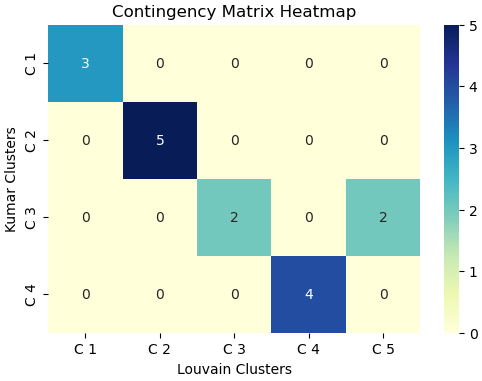

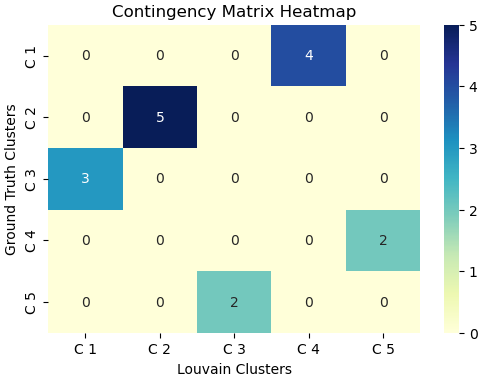

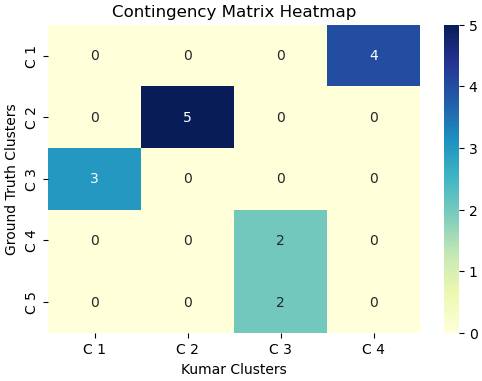

In [182]:
groundTruth = [{'bin4', 'bin5', 'bin6', 'bin3'}, {'bin11', 'bin10','bin12', 'bin14', 'bin13'},
    {'bin7', 'bin8', 'bin9'}, 
    {'bin16', 'bin15'}, {'bin2', 'bin1'}]

plotAlgoComparison(kumClust_pI_BLF,louClust_pI_BLF,"Louvain","Kumar")
plotAlgoComparison(groundTruth,louClust_pI_BLF,"Louvain","Ground Truth")
plotAlgoComparison(groundTruth,kumClust_pI_BLF,"Kumar","Ground Truth")

#### Generate a histogram of weights

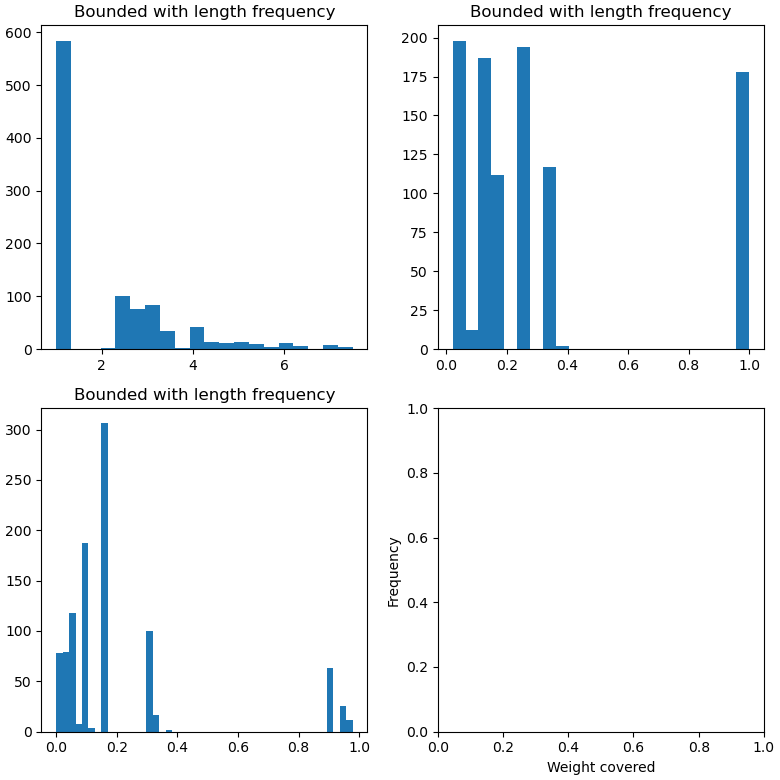

In [173]:
# Generate histogram of weights

f, axs = plt.subplots(
    figsize=(8,8),
    ncols=2, nrows = 2)

ax = axs[0,0]
ax.hist(unBoundedWeights, bins='auto')
ax.set_title('Bounded with length frequency')

ax = axs[0,1]
ax.hist(boundedWeights, bins='auto')
ax.set_title('Bounded with length frequency')

ax = axs[1,0]
ax.hist(boundedLFWeights, bins='auto')
ax.set_title('Bounded with length frequency')

# Display the histogram
plt.xlabel('Weight covered')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()